looking at change in entries at a particular timestampe across 8/31 --> 9/1/2021 by turnstile

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import contextily as cx

In [2]:
engine= create_engine('sqlite:///mta_data.db')
engine.table_names()

['mta_data']

In [3]:
df=pd.read_sql('SELECT * FROM mta_data where DATE in ("08/30/2021","08/31/2021","09/01/2021");',engine)

In [4]:
df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2021,00:00:00,REGULAR,7626814,2609397
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2021,04:00:00,REGULAR,7626820,2609401
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2021,08:00:00,REGULAR,7626832,2609438
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2021,12:00:00,REGULAR,7626903,2609558
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/30/2021,16:00:00,REGULAR,7627063,2609591
...,...,...,...,...,...,...,...,...,...,...,...
90757,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,07:31:50,REGULAR,5554,616
90758,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,09:00:00,REGULAR,5554,616
90759,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,13:00:00,REGULAR,5554,616
90760,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,17:00:00,REGULAR,5554,616


In [5]:
df.shape #10,897,397 x 11

(90762, 11)

In [6]:
#look at just two days 
df_20210901 = df

#clean data
df_20210901.columns = [column.strip() for column in df_20210901.columns]
df_20210901["DATE_TIME"] = pd.to_datetime(df_20210901.DATE + " " + df_20210901.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [7]:
df_20210901.tail()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
90757,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,07:31:50,REGULAR,5554,616,2021-09-01 07:31:50
90758,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,09:00:00,REGULAR,5554,616,2021-09-01 09:00:00
90759,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,13:00:00,REGULAR,5554,616,2021-09-01 13:00:00
90760,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,17:00:00,REGULAR,5554,616,2021-09-01 17:00:00
90761,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,21:00:00,REGULAR,5554,616,2021-09-01 21:00:00


In [8]:
#check for any duplicate rows
(df_20210901
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
90029,S101,R070,00-00-02,ST. GEORGE,2021-08-30 12:00:00,2
90038,S101,R070,00-00-02,ST. GEORGE,2021-09-01 00:00:00,2
90040,S101,R070,00-00-02,ST. GEORGE,2021-09-01 08:00:00,2
45714,N535,R220,00-00-00,CARROLL ST,2021-08-31 16:00:00,2
90042,S101,R070,00-00-02,ST. GEORGE,2021-09-01 16:00:00,2


In [9]:
#filter on the duplicate to see what the issue is 
mask = ((df_20210901["C/A"] == "S101") & 
(df_20210901["UNIT"] == "R070") & 
(df_20210901["SCP"] == "00-00-02") & 
(df_20210901["STATION"] == "ST. GEORGE")&
(df_20210901["DATE_TIME"]=="2021-09-01 20:00:00")	)

df_20210901[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
90052,S101,R070,00-00-02,ST. GEORGE,1,SRT,09/01/2021,20:00:00,REGULAR,1396413,324,2021-09-01 20:00:00
90053,S101,R070,00-00-02,ST. GEORGE,1,SRT,09/01/2021,20:00:00,RECOVR AUD,1213476,140,2021-09-01 20:00:00


In [10]:
#remove duplicate rows
df_20210901.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df_20210901.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)    
df_20210901.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
90761,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,21:00:00,REGULAR,5554,616,2021-09-01 21:00:00
90760,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,17:00:00,REGULAR,5554,616,2021-09-01 17:00:00
90759,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,13:00:00,REGULAR,5554,616,2021-09-01 13:00:00
90758,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,09:00:00,REGULAR,5554,616,2021-09-01 09:00:00
90757,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/01/2021,07:31:50,REGULAR,5554,616,2021-09-01 07:31:50


In [11]:
#check to see if the duplicate has been removed
mask = ((df_20210901["C/A"] == "S101") & 
(df_20210901["UNIT"] == "R070") & 
(df_20210901["SCP"] == "00-00-02") & 
(df_20210901["STATION"] == "ST. GEORGE")&
(df_20210901["DATE_TIME"]=="2021-09-01 20:00:00"))

df_20210901[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
90052,S101,R070,00-00-02,ST. GEORGE,1,SRT,09/01/2021,20:00:00,REGULAR,1396413,324,2021-09-01 20:00:00


In [12]:
#check data for one turnstile
mask = ((df_20210901["C/A"] == "A002") & 
(df_20210901["UNIT"] == "R051") & 
(df_20210901["SCP"] == "02-00-00") & 
(df_20210901["STATION"] == "JFK JAMAICA CT1"))

df_20210901[mask]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME


In [13]:
turnstiles_daily = (df_20210901
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .agg({"ENTRIES":"first","EXITS":"first"})
)

In [14]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,08/30/2021,7627322,2609623
1,A002,R051,02-00-00,59 ST,08/31/2021,7627947,2609878
2,A002,R051,02-00-00,59 ST,09/01/2021,7628463,2610143
3,A002,R051,02-00-01,59 ST,08/30/2021,6746869,1540762
4,A002,R051,02-00-01,59 ST,08/31/2021,6747286,1540940


In [15]:
#what is the total entries/exits for a timestamp at a turnstile
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE","ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily.head()
                                            

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_872/1190403995.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,08/30/2021,7627322,2609623,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/31/2021,7627947,2609878,08/30/2021,7627322.0,2609623.0
2,A002,R051,02-00-00,59 ST,09/01/2021,7628463,2610143,08/31/2021,7627947.0,2609878.0
3,A002,R051,02-00-01,59 ST,08/30/2021,6746869,1540762,NaN,NaN,NaN
4,A002,R051,02-00-01,59 ST,08/31/2021,6747286,1540940,08/30/2021,6746869.0,1540762.0


In [16]:
# Drop the rows for the earliest date_time stamp in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,08/31/2021,7627947,2609878,08/30/2021,7627322.0,2609623.0
2,A002,R051,02-00-00,59 ST,09/01/2021,7628463,2610143,08/31/2021,7627947.0,2609878.0
4,A002,R051,02-00-01,59 ST,08/31/2021,6747286,1540940,08/30/2021,6746869.0,1540762.0
5,A002,R051,02-00-01,59 ST,09/01/2021,6747659,1541105,08/31/2021,6747286.0,1540940.0
7,A002,R051,02-03-00,59 ST,08/31/2021,1450542,5483876,08/30/2021,1450315.0,5482894.0


In [17]:
# reverse entries i.e. previous entries are larger than current entries 
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
118,A011,R080,01-03-00,57 ST-7 AV,08/31/2021,885577465,489492692,08/30/2021,8.855777e+08,4.894937e+08
119,A011,R080,01-03-00,57 ST-7 AV,09/01/2021,885577193,489491661,08/31/2021,8.855775e+08,4.894927e+08
844,A066,R118,00-00-00,CANAL ST,08/31/2021,1722549504,1763893952,08/30/2021,1.722551e+09,1.763893e+09
845,A066,R118,00-00-00,CANAL ST,09/01/2021,1722548337,1763895436,08/31/2021,1.722550e+09,1.763894e+09
1465,C008,R099,00-00-00,DEKALB AV,08/31/2021,1999493207,1851118300,08/30/2021,1.999494e+09,1.851117e+09


In [18]:
# Counters counting in reverse -see how many stations have this problem
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A011   R080  01-03-00  57 ST-7 AV         2
A066   R118  00-00-00  CANAL ST           2
C008   R099  00-00-00  DEKALB AV          2
D011   R394  01-06-00  BAY PKWY           2
             01-06-01  BAY PKWY           2
H003   R163  01-00-02  6 AV               2
H023   R236  00-00-01  DEKALB AV          2
             00-06-00  DEKALB AV          2
J003   R352  00-00-00  HEWES ST           2
K026   R100  00-00-01  METROPOLITAN AV    2
N006A  R280  00-00-00  190 ST             2
N009   R174  01-00-02  181 ST             2
N056   R188  01-00-03  50 ST              2
N063A  R011  00-00-04  42 ST-PORT AUTH    2
             00-00-05  42 ST-PORT AUTH    2
             00-00-08  42 ST-PORT AUTH    2
N078   R175  01-00-03  14 ST              2
N110   R283  00-06-00  LAFAYETTE AV       2
N137   R354  00-06-01  104 ST             2
N203   R195  00-00-01  161/YANKEE STAD    2
N207   R104  00-00-00  167 ST             2
N215   R237  00-00-02  182-183 STS   

In [19]:
# What's the deal with counter being in reverse
mask = ((turnstiles_daily["C/A"] == "A011") & 
(turnstiles_daily["UNIT"] == "R080") & 
(turnstiles_daily["SCP"] == "01-03-00") & 
(turnstiles_daily["STATION"] == "57 ST-7 AV") &
(turnstiles_daily["DATE"]== "08/31/2021"))

turnstiles_daily[mask].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
118,A011,R080,01-03-00,57 ST-7 AV,08/31/2021,885577465,489492692,08/30/2021,885577734.0,489493747.0


In [20]:
#calculate counts for entries

def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

21 120055.0
1396283 1213236.0


In [21]:
#calculate counts for exits

def get_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

24 287720.0


In [22]:
#check the calculation 
mask = ((turnstiles_daily["C/A"] == "A011") & 
(turnstiles_daily["UNIT"] == "R080") & 
(turnstiles_daily["SCP"] == "01-03-00") & 
(turnstiles_daily["STATION"] == "57 ST-7 AV") )

turnstiles_daily[mask].head()


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
118,A011,R080,01-03-00,57 ST-7 AV,08/31/2021,885577465,489492692,08/30/2021,885577734.0,489493747.0,269.0,1055.0
119,A011,R080,01-03-00,57 ST-7 AV,09/01/2021,885577193,489491661,08/31/2021,885577465.0,489492692.0,272.0,1031.0


In [23]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()
station_daily["DAILY_TOTALS"]= station_daily["DAILY_ENTRIES"]+station_daily["DAILY_EXITS"]
station_daily.head()

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_872/546621034.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
0,1 AV,08/31/2021,7780.0,13684.0,21464.0
1,1 AV,09/01/2021,7819.0,14347.0,22166.0
2,103 ST,08/31/2021,11899.0,13465.0,25364.0
3,103 ST,09/01/2021,11496.0,13105.0,24601.0
4,103 ST-CORONA,08/31/2021,10742.0,12101.0,22843.0


In [24]:
prcp_df = pd.read_csv('daily_prcp_2021.csv')
prcp_df =  prcp_df[['date','prcp','snow']]

In [25]:
prcp_df

,date,prcp,snow
0,01/01/2021,16.8,0
1,01/02/2021,1.5,0
2,01/03/2021,4.1,0
3,01/04/2021,0.3,0
4,01/05/2021,0.0,0
...,...,...,...
360,12/27/2021,2.0,0
361,12/28/2021,1.3,0
362,12/29/2021,4.1,0
363,12/30/2021,1.3,0


In [26]:
#merge precipitation data with turnstile data
turnstiles_daily_prcp = pd.merge(station_daily
                            , prcp_df
                            , how='left' 
                            , left_on=['DATE']
                            , right_on=['date']
)


In [27]:
turnstiles_daily_prcp

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,date,prcp,snow
0,1 AV,08/31/2021,7780.0,13684.0,21464.0,08/31/2021,0.0,0
1,1 AV,09/01/2021,7819.0,14347.0,22166.0,09/01/2021,172.7,0
2,103 ST,08/31/2021,11899.0,13465.0,25364.0,08/31/2021,0.0,0
3,103 ST,09/01/2021,11496.0,13105.0,24601.0,09/01/2021,172.7,0
4,103 ST-CORONA,08/31/2021,10742.0,12101.0,22843.0,08/31/2021,0.0,0
...,...,...,...,...,...,...,...,...
753,WTC-CORTLANDT,09/01/2021,2755.0,3455.0,6210.0,09/01/2021,172.7,0
754,YORK ST,08/31/2021,3771.0,4534.0,8305.0,08/31/2021,0.0,0
755,YORK ST,09/01/2021,3400.0,4171.0,7571.0,09/01/2021,172.7,0
756,ZEREGA AV,08/31/2021,1033.0,1348.0,2381.0,08/31/2021,0.0,0


In [28]:
#pull out only 8/31 data 
df_0831 =turnstiles_daily_prcp[(turnstiles_daily_prcp.DATE == '08/31/2021')][
                            ["STATION","DATE","DAILY_ENTRIES","DAILY_EXITS","DAILY_TOTALS","prcp"]]
df_0831.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,prcp
0,1 AV,08/31/2021,7780.0,13684.0,21464.0,0.0
2,103 ST,08/31/2021,11899.0,13465.0,25364.0,0.0
4,103 ST-CORONA,08/31/2021,10742.0,12101.0,22843.0,0.0
6,104 ST,08/31/2021,2089.0,1458.0,3547.0,0.0
8,110 ST,08/31/2021,4345.0,5843.0,10188.0,0.0


In [29]:
#pull out only 9/1 data
df_0901 =turnstiles_daily_prcp[(turnstiles_daily_prcp.DATE == '09/01/2021')][
                            ["STATION","DATE","DAILY_ENTRIES","DAILY_EXITS","DAILY_TOTALS","prcp"]]
df_0901.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,prcp
1,1 AV,09/01/2021,7819.0,14347.0,22166.0,172.7
3,103 ST,09/01/2021,11496.0,13105.0,24601.0,172.7
5,103 ST-CORONA,09/01/2021,10752.0,12503.0,23255.0,172.7
7,104 ST,09/01/2021,2004.0,1540.0,3544.0,172.7
9,110 ST,09/01/2021,4191.0,5935.0,10126.0,172.7


In [30]:
#merge the two date's data frames
df_merged = pd.merge(df_0831
                            , df_0901
                            , how='inner' 
                            , left_on=["STATION"]
                            , right_on=["STATION"]
)[["STATION","DATE_x","prcp_x","DAILY_ENTRIES_x","DAILY_EXITS_x","DAILY_TOTALS_x","DATE_y","prcp_y","DAILY_ENTRIES_y","DAILY_EXITS_y","DAILY_TOTALS_y"]]

df_merged.head()

,STATION,DATE_x,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,DATE_y,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y
0,1 AV,08/31/2021,0.0,7780.0,13684.0,21464.0,09/01/2021,172.7,7819.0,14347.0,22166.0
1,103 ST,08/31/2021,0.0,11899.0,13465.0,25364.0,09/01/2021,172.7,11496.0,13105.0,24601.0
2,103 ST-CORONA,08/31/2021,0.0,10742.0,12101.0,22843.0,09/01/2021,172.7,10752.0,12503.0,23255.0
3,104 ST,08/31/2021,0.0,2089.0,1458.0,3547.0,09/01/2021,172.7,2004.0,1540.0,3544.0
4,110 ST,08/31/2021,0.0,4345.0,5843.0,10188.0,09/01/2021,172.7,4191.0,5935.0,10126.0


In [31]:
df_merged.describe()

,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y
count,379.0,379.000000,379.000000,379.000000,3.790000e+02,379.000000,379.000000,379.000000
mean,0.0,5526.651715,6365.802111,11892.453826,1.727000e+02,5208.984169,6099.949868,11308.934037
std,0.0,6505.589464,8541.156079,14954.538853,1.195290e-12,6205.654978,8164.936861,14287.317762
min,0.0,0.000000,0.000000,2.000000,1.727000e+02,0.000000,0.000000,0.000000
25%,0.0,1921.500000,1718.500000,3640.000000,1.727000e+02,1773.500000,1703.000000,3574.500000
50%,0.0,3449.000000,3637.000000,6862.000000,1.727000e+02,3184.000000,3502.000000,6504.000000
75%,0.0,6285.500000,6944.500000,13487.000000,1.727000e+02,5699.500000,6701.500000,13057.000000
max,0.0,49364.000000,63418.000000,112782.000000,1.727000e+02,47548.000000,61962.000000,109510.000000


In [32]:
#calculate the change in entries/exits at a particular turnstile over the two days

df_merged["TOTAL_p_delta"]= df_merged.DAILY_TOTALS_y/df_merged.DAILY_TOTALS_x-1 
df_merged["TOTAL_delta"]= df_merged.DAILY_TOTALS_y-df_merged.DAILY_TOTALS_x 

df_merged

,STATION,DATE_x,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,DATE_y,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y,TOTAL_p_delta,TOTAL_delta
0,1 AV,08/31/2021,0.0,7780.0,13684.0,21464.0,09/01/2021,172.7,7819.0,14347.0,22166.0,0.032706,702.0
1,103 ST,08/31/2021,0.0,11899.0,13465.0,25364.0,09/01/2021,172.7,11496.0,13105.0,24601.0,-0.030082,-763.0
2,103 ST-CORONA,08/31/2021,0.0,10742.0,12101.0,22843.0,09/01/2021,172.7,10752.0,12503.0,23255.0,0.018036,412.0
3,104 ST,08/31/2021,0.0,2089.0,1458.0,3547.0,09/01/2021,172.7,2004.0,1540.0,3544.0,-0.000846,-3.0
4,110 ST,08/31/2021,0.0,4345.0,5843.0,10188.0,09/01/2021,172.7,4191.0,5935.0,10126.0,-0.006086,-62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,WOODLAWN,08/31/2021,0.0,3518.0,1416.0,4934.0,09/01/2021,172.7,3201.0,1225.0,4426.0,-0.102959,-508.0
375,WORLD TRADE CTR,08/31/2021,0.0,4344.0,5261.0,9605.0,09/01/2021,172.7,3813.0,4958.0,8771.0,-0.086830,-834.0
376,WTC-CORTLANDT,08/31/2021,0.0,2916.0,3597.0,6513.0,09/01/2021,172.7,2755.0,3455.0,6210.0,-0.046522,-303.0
377,YORK ST,08/31/2021,0.0,3771.0,4534.0,8305.0,09/01/2021,172.7,3400.0,4171.0,7571.0,-0.088380,-734.0


In [33]:
#top increases 
top_increases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_delta",ascending= False)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_delta"]]

top_increases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
107,81 ST-MUSEUM,08/31/2021,09/01/2021,8477.0,11084.0,2607.0
30,176 ST,08/31/2021,09/01/2021,4259.0,5705.0,1446.0
361,VAN SICLEN AVE,08/31/2021,09/01/2021,2190.0,3576.0,1386.0
181,CHAUNCEY ST,08/31/2021,09/01/2021,1741.0,2717.0,976.0
209,EASTN PKWY-MUSM,08/31/2021,09/01/2021,3761.0,4612.0,851.0
72,47-50 STS ROCK,08/31/2021,09/01/2021,39596.0,40355.0,759.0
0,1 AV,08/31/2021,09/01/2021,21464.0,22166.0,702.0
287,MYRTLE AV,08/31/2021,09/01/2021,9058.0,9755.0,697.0
256,JFK JAMAICA CT1,08/31/2021,09/01/2021,8946.0,9588.0,642.0
323,PROSPECT AV,08/31/2021,09/01/2021,9031.0,9471.0,440.0


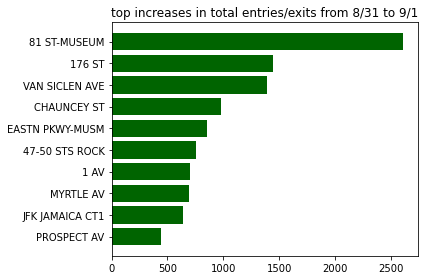

In [71]:

y = top_increases.TOTAL_delta
x = top_increases.STATION

plt.figure(facecolor='white')

plt.barh (x,y,color='#006400')
plt.gca().invert_yaxis()
plt.title ("top increases in total entries/exits from 8/31 to 9/1")
plt.tight_layout()
plt.savefig('top_increases_20210901.png',bbox_inches='tight')

In [35]:
#top % increases 
top_p_increases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_p_delta",ascending= False)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_p_delta"]]

top_p_increases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_p_delta
361,VAN SICLEN AVE,08/31/2021,09/01/2021,2190.0,3576.0,0.632877
181,CHAUNCEY ST,08/31/2021,09/01/2021,1741.0,2717.0,0.560597
30,176 ST,08/31/2021,09/01/2021,4259.0,5705.0,0.339516
107,81 ST-MUSEUM,08/31/2021,09/01/2021,8477.0,11084.0,0.307538
209,EASTN PKWY-MUSM,08/31/2021,09/01/2021,3761.0,4612.0,0.226270
126,ATLANTIC AV,08/31/2021,09/01/2021,1191.0,1298.0,0.089840
287,MYRTLE AV,08/31/2021,09/01/2021,9058.0,9755.0,0.076949
256,JFK JAMAICA CT1,08/31/2021,09/01/2021,8946.0,9588.0,0.071764
94,69 ST,08/31/2021,09/01/2021,6178.0,6504.0,0.052768
82,55 ST,08/31/2021,09/01/2021,1783.0,1872.0,0.049916


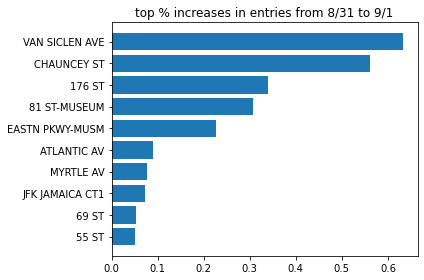

In [36]:

y = top_p_increases.TOTAL_p_delta
x = top_p_increases.STATION

plt.figure(facecolor='white')

plt.barh (x,y)
plt.gca().invert_yaxis()
plt.title ("top % increases in entries from 8/31 to 9/1")
plt.tight_layout()
plt.savefig('top_p_increases.png')

In [37]:
#top decreases 
top_decreases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_delta",ascending= True)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_delta"]]

top_decreases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
226,FULTON ST,08/31/2021,09/01/2021,64223.0,58598.0,-5625.0
14,14 ST-UNION SQ,08/31/2021,09/01/2021,76871.0,71399.0,-5472.0
315,PATH NEW WTC,08/31/2021,09/01/2021,42367.0,36908.0,-5459.0
110,86 ST,08/31/2021,09/01/2021,75939.0,71264.0,-4675.0
173,CANAL ST,08/31/2021,09/01/2021,48862.0,44583.0,-4279.0
15,145 ST,08/31/2021,09/01/2021,36432.0,32275.0,-4157.0
59,34 ST-HERALD SQ,08/31/2021,09/01/2021,87973.0,84106.0,-3867.0
353,TIMES SQ-42 ST,08/31/2021,09/01/2021,64193.0,60333.0,-3860.0
217,FLUSHING-MAIN,08/31/2021,09/01/2021,58931.0,55267.0,-3664.0
115,96 ST,08/31/2021,09/01/2021,52886.0,49294.0,-3592.0


In [38]:
top_decreases[["STATION"]]

,STATION
226,FULTON ST
14,14 ST-UNION SQ
315,PATH NEW WTC
110,86 ST
173,CANAL ST
15,145 ST
59,34 ST-HERALD SQ
353,TIMES SQ-42 ST
217,FLUSHING-MAIN
115,96 ST


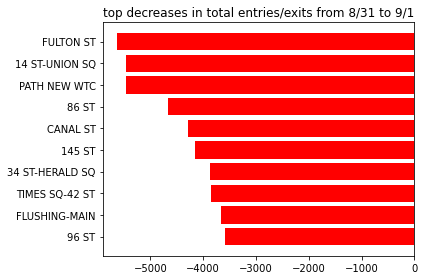

In [70]:

y = top_decreases.TOTAL_delta.sort_values(ascending = True)
x = top_decreases.STATION

plt.figure(facecolor='white')

plt.barh (x,y,color ='r')
plt.gca().invert_yaxis()
plt.title ("top decreases in total entries/exits from 8/31 to 9/1") 
plt.tight_layout()
plt.savefig('top_decreases_20210901.png')

In [40]:
#top % decreases 
top_p_decreases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_p_delta",ascending= True)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_p_delta"]]

top_p_decreases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_p_delta
309,ORCHARD BEACH,08/31/2021,09/01/2021,2.0,0.0,-1.000000
141,BEACH 105 ST,08/31/2021,09/01/2021,346.0,203.0,-0.413295
329,RIT-MANHATTAN,08/31/2021,09/01/2021,2189.0,1364.0,-0.376884
330,RIT-ROOSEVELT,08/31/2021,09/01/2021,1912.0,1256.0,-0.343096
364,W 8 ST-AQUARIUM,08/31/2021,09/01/2021,3165.0,2106.0,-0.334597
295,NEW LOTS,08/31/2021,09/01/2021,5966.0,4454.0,-0.253436
317,PAVONIA/NEWPORT,08/31/2021,09/01/2021,13372.0,10280.0,-0.231229
117,9TH STREET,08/31/2021,09/01/2021,5025.0,3870.0,-0.229851
228,GRAHAM AV,08/31/2021,09/01/2021,7088.0,5467.0,-0.228696
190,CONEY IS-STILLW,08/31/2021,09/01/2021,14846.0,11719.0,-0.210629


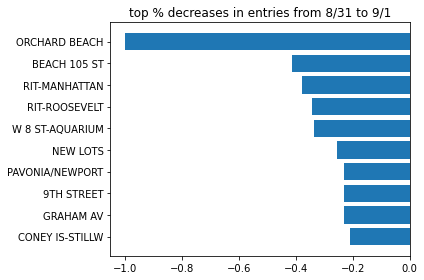

In [41]:
y = top_p_decreases.TOTAL_p_delta.sort_values(ascending = True)
x = top_p_decreases.STATION

plt.figure(facecolor='white')

plt.barh (x,y)
plt.gca().invert_yaxis()
plt.title ("top % decreases in entries from 8/31 to 9/1")
plt.tight_layout()
plt.savefig('top_p_decreases.png')

In [42]:
#check the calculation 
mask = (
(df_merged["STATION"] == "145 ST") |
(df_merged["STATION"] == "28 ST")
)

df_merged[mask].head()

,STATION,DATE_x,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,DATE_y,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y,TOTAL_p_delta,TOTAL_delta
15,145 ST,08/31/2021,0.0,15804.0,20628.0,36432.0,09/01/2021,172.7,13960.0,18315.0,32275.0,-0.114103,-4157.0
52,28 ST,08/31/2021,0.0,14331.0,20776.0,35107.0,09/01/2021,172.7,14720.0,20735.0,35455.0,0.009913,348.0


In [43]:
mask = (
(df["STATION"] == "145 ST") &
(df["DATE_TIME"].dt.date == datetime.datetime(2021, 9, 1).date()))

df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
75432,R308,R344,00-03-01,145 ST,3,IRT,09/01/2021,20:00:00,REGULAR,344296,44727,2021-09-01 20:00:00
75431,R308,R344,00-03-01,145 ST,3,IRT,09/01/2021,16:00:00,REGULAR,344227,44718,2021-09-01 16:00:00
75430,R308,R344,00-03-01,145 ST,3,IRT,09/01/2021,12:00:00,REGULAR,344171,44707,2021-09-01 12:00:00
75429,R308,R344,00-03-01,145 ST,3,IRT,09/01/2021,08:00:00,REGULAR,344080,44691,2021-09-01 08:00:00
75428,R308,R344,00-03-01,145 ST,3,IRT,09/01/2021,04:00:00,REGULAR,344018,44679,2021-09-01 04:00:00


In [44]:
#Mapping 
locations = pd.read_csv('nyc_transit_location_data.csv')
locations = locations[["Station Name","Station Latitude","Station Longitude"]]
geometry = [Point(xy) for xy in zip(locations["Station Latitude"], locations["Station Longitude"])]
gdf = GeoDataFrame(locations, geometry=geometry)
gdf.set_crs(epsg=4326, inplace = True)



,Station Name,Station Latitude,Station Longitude,geometry
0,103rd St,40.796092,-73.961454,POINT (40.79609 -73.96145)
1,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
2,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
3,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
4,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
...,...,...,...,...
1863,Yankee Stadium-161st St,40.827994,-73.925831,POINT (40.82799 -73.92583)
1864,Yankee Stadium-161st St,40.827994,-73.925831,POINT (40.82799 -73.92583)
1865,York St,40.699743,-73.986885,POINT (40.69974 -73.98689)
1866,Zerega Av,40.836488,-73.847036,POINT (40.83649 -73.84704)


In [45]:
#only extract rows we're interested in
gdf_subset= gdf.iloc[[1219,146,1841,689,95,195,376,1739,1163,719],:].append( #top decreases
    gdf.iloc[[669,214,1774,1009,1123,46,249,1522,1359,1614],:]).reset_index()#top increases


#merge geopanda with movement data
movement= top_decreases.append(top_increases).reset_index()
merged_gdf = pd.merge(gdf_subset,movement,left_index=True, right_index=True)
merged_gdf

,index_x,Station Name,Station Latitude,Station Longitude,geometry,index_y,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
0,1219,Fulton St,40.709416,-74.006571,POINT (40.70942 -74.00657),226,FULTON ST,08/31/2021,09/01/2021,64223.0,58598.0,-5625.0
1,146,14th St-Union Square,40.734673,-73.989951,POINT (40.73467 -73.98995),14,14 ST-UNION SQ,08/31/2021,09/01/2021,76871.0,71399.0,-5472.0
2,1841,World Trade Center,40.712582,-74.009781,POINT (40.71258 -74.00978),315,PATH NEW WTC,08/31/2021,09/01/2021,42367.0,36908.0,-5459.0
3,689,86th St,40.779492,-73.955589,POINT (40.77949 -73.95559),110,86 ST,08/31/2021,09/01/2021,75939.0,71264.0,-4675.0
4,95,145th St,40.824783,-73.944216,POINT (40.82478 -73.94422),173,CANAL ST,08/31/2021,09/01/2021,48862.0,44583.0,-4279.0
5,195,170th St,40.839306,-73.913400,POINT (40.83931 -73.91340),15,145 ST,08/31/2021,09/01/2021,36432.0,32275.0,-4157.0
6,376,34th St,40.749719,-73.987823,POINT (40.74972 -73.98782),59,34 ST-HERALD SQ,08/31/2021,09/01/2021,87973.0,84106.0,-3867.0
7,1739,Times Square,40.755290,-73.987495,POINT (40.75529 -73.98749),353,TIMES SQ-42 ST,08/31/2021,09/01/2021,64193.0,60333.0,-3860.0
8,1163,Flushing-Main St,40.759600,-73.830030,POINT (40.75960 -73.83003),217,FLUSHING-MAIN,08/31/2021,09/01/2021,58931.0,55267.0,-3664.0
9,719,96th St,40.791646,-73.964699,POINT (40.79165 -73.96470),115,96 ST,08/31/2021,09/01/2021,52886.0,49294.0,-3592.0


In [46]:
#read in geomaps
#df = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(epsg=4326)
#df = df.drop(df.index[0]) #drop Staten Island
#df["area"] = df.area
flood_df = gpd.read_file('NYC Stormwater Flood Map - Extreme Flood.gdb').to_crs(epsg=4326)

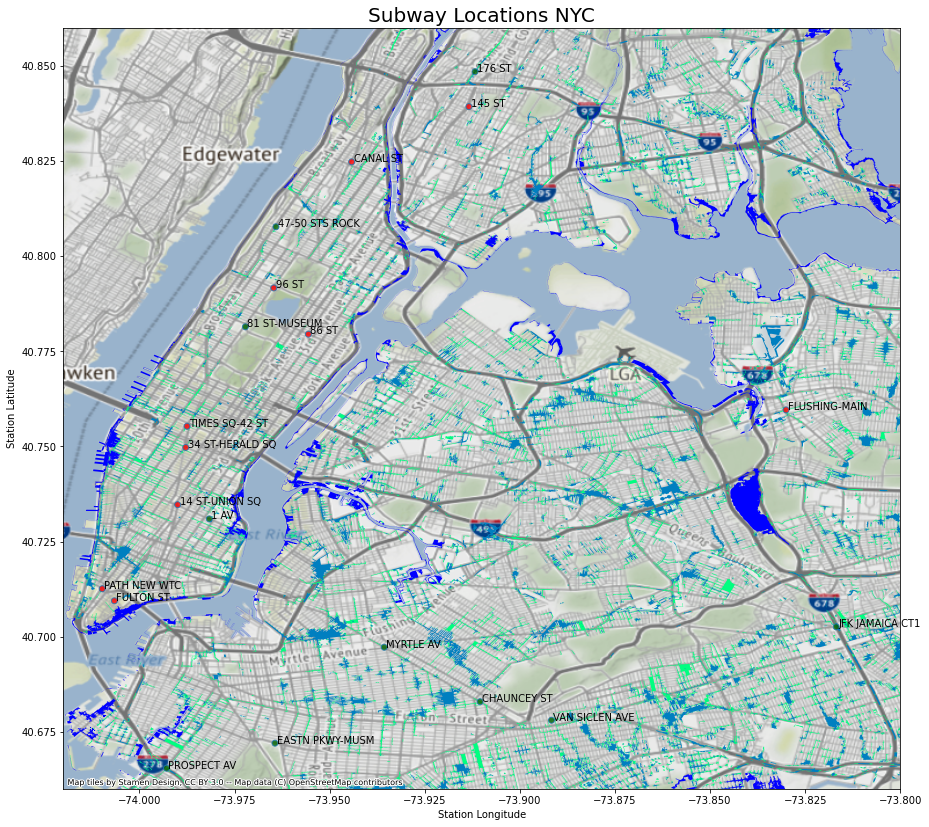

<Figure size 432x288 with 0 Axes>

In [72]:
#Flood Mapping 
ax = flood_df.plot(column='Flooding_Category',figsize=(15, 15),cmap="winter_r")
minx, miny, maxx, maxy = flood_df.total_bounds
ax.set_xlim(-74.02, -73.8)
ax.set_ylim(40.66, 40.86)
cx.add_basemap(ax, crs='EPSG:4326')

#customize color of stations & plot
value=(merged_gdf['TOTAL_delta']<0)
merged_gdf['color']= np.where( value==True , "r", "#006400")

sns.regplot(data=merged_gdf, x="Station Longitude", y="Station Latitude",
          fit_reg=False, marker="o", scatter_kws={'facecolor':merged_gdf['color']})
 
# add annotations one by one with a loop
for line in range(0,merged_gdf.shape[0]):
     plt.text(merged_gdf["Station Longitude"][line]+0.0005, merged_gdf["Station Latitude"][line], merged_gdf["STATION"][line],
     horizontalalignment='left', size='medium', color='black', weight='normal')

plt.title("Subway Locations NYC", size=20)
plt.show()
plt.savefig('map_20210901.png')
